In [1]:
from glob import glob
import pandas as pd
import numpy as np

### Create the training dataset

In [2]:
# Extract the subjects' label.
path_labels = '../data/risk_golden_truth.txt'
labels = {}
with open(path_labels, 'r') as f:
    for line in f:
        subject, label = line.split()
        labels[subject] = int(label)

In [3]:
# Create the train dataset from the subjects' posts and label.
txt_path = glob('../data/processed/*')
rows_data = []
for path in txt_path:
   with open(path, 'r+') as f:
      # Split the path, get the filename 
      # (which contains the subject) and remove '.txt'
      subject = path.split('\\')[1][:-4] 
      txt = f.read()
      rows_data.append((subject, txt, labels[subject]))

# Training dataset.
train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])

In [4]:
train_data

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject100,I almost only play Marathon/Huge. I enjoy slow...,0
2,subject1006,http://imgur.com/igov5qk http://imgur.com/vHu8...,0
3,subject1008,What are the list of softwares you use for day...,0
4,subject1011,Subscribe and like will help me #128522;\nLoL\...,0
...,...,...,...
2343,subject9980,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2344,subject9981,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2345,subject9986,Checkout r/GoGoJoJo against the qualified immu...,0
2346,subject9990,Only took about 10 tries to post correctly lol...,0


### Preprocess the subjects' posts
Text normalization techniques:
- lowercasing 
- whitespace removal
- URL removal
- tokenization
- stopwords removal
- punctuation removal
- stemming

In [5]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [6]:
# Normalize all words to lowercase.
train_data["Text"] = train_data["Text"].str.lower()

In [7]:
def remove_whitespace(text):
   """ Removes all whitespaces from a given text."""
   return " ".join(text.split())

In [8]:
# Remove all whitespaces from texts.
train_data["Text"] = train_data["Text"].apply(remove_whitespace)

In [9]:
def remove_URLs(text):
   "Remove URLs from text using regular expressions."
   url_re = re.compile(r'https?://\S+|www\.\S+')
   return url_re.sub(r'', text)

In [10]:
train_data["Text"][2][:200]

'http://imgur.com/igov5qk http://imgur.com/vhu8cjn this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weap'

In [11]:
# Remove URLs from texts.
train_data["Text"] = train_data["Text"].apply(remove_URLs)

In [12]:
train_data["Text"][2][:200]

'  this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weapons system, and someone truly blessed me. triple'

In [13]:
# Extract tokens from texts.
train_data["Text"] = train_data["Text"].apply(lambda x: word_tokenize(x))

In [14]:
def remove_punctuation(text):
   tokenizer = RegexpTokenizer(r'\w+')
   no_punct = tokenizer.tokenize(" ".join(text))
   return no_punct

In [15]:
# Removes punctuation from texts.
train_data["Text"] = train_data["Text"].apply(remove_punctuation)

In [16]:
en_stopwords = stopwords.words('english')
def remove_stopwords(text):
   """Removes english stopwords."""
   result = []
   for token in text:
      if token not in en_stopwords:
         result.append(token)

   return result

In [17]:
# Removes stopwords from texts.
train_data["Text"] = train_data["Text"].apply(remove_stopwords)

In [18]:
def stemming(text):
   porter = PorterStemmer()
   result = []
   for word in text:
      result.append(porter.stem(word))

   return result

In [19]:
# Apply stemming to words from texts.
train_data["Text"] = train_data["Text"].apply(stemming)

In [20]:
# Save the dataset to a .csv file.
train_data.to_csv('../data/train_dataset.csv')

### Standard ML approaches:
- LinearSVC
- Logistic Regression

In [ ]:
# Load the training dataset.
train_data = pd.read_csv('../data/train_dataset.csv')

<AxesSubplot:>

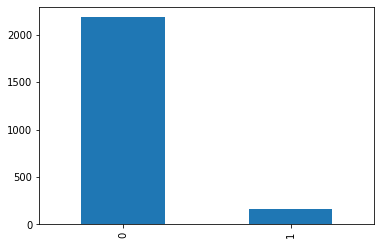

In [21]:
# Visualize the distribution of data labels.
train_data["Label"].value_counts().plot.bar()

### Baseline model - Linear SVC:

In [68]:
import time
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [64]:
X = train_data["Text"].apply(" ".join)
y = train_data["Label"]
# Extract BOW using CountVectorizer().
feature_extractor = CountVectorizer(lowercase=False)
classifier = LinearSVC(max_iter=1000, class_weight='balanced')

pipeline = Pipeline([('feature extractor', feature_extractor), ('classifier', classifier)])
# Use a stratified 5-fold CV 
# to try to reduce the class imbalance in train/test splits.
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

In [65]:
print("F1 score for BOW + LinearSVC:", np.mean(scores))

F1 score for BOW + LinearSVC: 0.8664433067750116


### ML experiments:
- Logistic Regression
- Random Forest
- K-neighbors
- Decision Tree

In [72]:
feature_extractors = [CountVectorizer(), TfidfVectorizer()]
classifiers = [LinearSVC(max_iter=1000), LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier()]

for extractor in feature_extractors:
   for classifier in classifiers:
      start_time = time.time()
      pipeline = Pipeline([('feature extractor', extractor), ('classifier', classifier)])
      cv = StratifiedKFold(n_splits=5)
      scores = cross_val_score(pipeline, X, y, cv = cv, scoring='f1')
      end_time = time.time()
      
      print("Time: ", round((end_time - start_time)/60, 2), " min")
      print("Experiment: ", str(extractor), "+", str(classifier))
      print("F1 score=", scores, " mean=", np.mean(scores))
      print("="*100)

Time:  1.03  min
Experiment:  CountVectorizer() + LinearSVC()
F1 score= [0.82191781 0.87878788 0.84848485 0.85294118 0.8358209 ]  mean= 0.8475905214969763
Time:  2.65  min
Experiment:  CountVectorizer() + LogisticRegression(max_iter=1000)
F1 score= [0.84057971 0.90625    0.84848485 0.87878788 0.8358209 ]  mean= 0.8619846665880087
Time:  1.19  min
Experiment:  CountVectorizer() + RandomForestClassifier()
F1 score= [0.35       0.42857143 0.42857143 0.51162791 0.46511628]  mean= 0.4367774086378738
Time:  1.09  min
Experiment:  CountVectorizer() + KNeighborsClassifier()
F1 score= [0.75       0.73076923 0.74074074 0.79245283 0.77192982]  mean= 0.7571785252520108
Time:  1.23  min
Experiment:  CountVectorizer() + DecisionTreeClassifier()
F1 score= [0.90909091 0.87096774 0.86666667 0.92063492 0.86153846]  mean= 0.8857797399732883
Time:  1.04  min
Experiment:  TfidfVectorizer() + LinearSVC()
F1 score= [0.88135593 0.88135593 0.86206897 0.95081967 0.88135593]  mean= 0.8913912868517118
Time:  1.21